In [25]:
# !pip install tqdm
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install torch
# !pip install torchvision
# !pip install kaggle
# !pip install --upgrade torchvision
# !pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.7 MB/s eta 0:00:0000:010:01


In [43]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    auc, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import torchvision.models as models
import json
from torchvision import datasets, transforms
import requests

from sklearn.metrics import precision_score, recall_score, f1_score
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

from sklearn.metrics import precision_score, recall_score, f1_score
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

import json
import torch
import torchvision.models as models
import torch.optim as optim


In [36]:
# os.environ['KAGGLE_USERNAME'] = "mohammadafdsfa"
# os.environ['KAGGLE_KEY'] = "759b23bd9824608f45638f383fecc36b"
# !kaggle datasets download -d qramkrishna/corn-leaf-infection-dataset
# with zipfile.ZipFile("corn-leaf-infection-dataset.zip", "r") as zip_ref:
#     zip_ref.extractall("corn-leaf-infection-dataset")

In [37]:
# -----------------------------------

In [44]:
import matplotlib.pyplot as plt

def save_plot(title, base_filename):
    formats = ['png', 'jpg', 'svg', 'pdf']
    for fmt in formats:
        plt.savefig(f"{base_filename}_{title}.{fmt}", format=fmt, dpi=1500, bbox_inches="tight")

In [55]:
def save_metrics_to_pdf(
    true_labels, predicted_classes, precision_per_class, recall_per_class, f1_per_class,
    precision_micro, recall_micro, f1_micro, precision_macro, recall_macro, f1_macro,
    model_name="model", output_directory=".", filename_suffix="metrics_results.pdf"
):
    pdf_file_name = f"{model_name}_{filename_suffix}"

    c = canvas.Canvas(pdf_file_name, pagesize=letter)
    c.setFont("Arial", 12) 
    
    content = [
        "Precision per class:" + str(precision_per_class),
        "Recall per class:" + str(recall_per_class),
        "F1 Score per class:" + str(f1_per_class),
        "Micro-average:",
        f'Precision: {precision_micro:.4f}',
        f'Recall: {recall_micro:.4f}',
        f'F1 Score: {f1_micro:.4f}',
        "Macro-average:",
        f'Precision: {precision_macro:.4f}',
        f'Recall: {recall_macro:.4f}',
        f'F1 Score: {f1_macro:.4f}',
    ]

    x, y = 50, 750

    for line in content:
        c.drawString(x, y, line)
        y -= 20 
    c.save()

    print(f"Results saved to {pdf_file_name}")

In [46]:
# def download_file(url, filename):
#     # Send a GET request to the URL
#     response = requests.get(url)

#     # Check if the request was successful
#     if response.status_code == 200:
#         with open(filename, 'wb') as file:
#             file.write(response.content)
#         print(f"Downloaded '{filename}' successfully.")
#     else:
#         print(f"Failed to download '{filename}'. Status code: {response.status_code}")

In [49]:
# font_url = 'https://www.cufonfonts.com/download/font/arial'
# font_filename = 'arial.ttf'

# download_file(font_url, font_filename)

In [52]:
pdfmetrics.registerFont(TTFont("Arial", "arial.ttf"))

In [5]:
# ---------------------------------------

In [85]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'corn-leaf-infection-dataset/Corn Disease detection'

combined_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

labels = []

for _, label in tqdm(combined_dataset, desc="Extracting Labels", unit="samples"):
    labels.append(label)

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_test_indices, validation_indices = next(stratified_splitter.split(np.zeros(len(labels)), labels))

train_size = int(0.6 * len(train_test_indices))
test_size = int(0.2 * len(train_test_indices))
validation_size = len(train_test_indices) - train_size - test_size

train_indices = train_test_indices[:train_size]
test_indices = train_test_indices[train_size:train_size + test_size]
validation_indices = train_test_indices[train_size + test_size:]

train_dataset = torch.utils.data.Subset(combined_dataset, train_indices)
test_dataset = torch.utils.data.Subset(combined_dataset, test_indices)
validation_dataset = torch.utils.data.Subset(combined_dataset, validation_indices)

batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

num_classes = len(combined_dataset.classes)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(validation_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Extracting Labels: 100%|███████████████████████████████████████████████████████| 4225/4225 [02:59<00:00, 23.56samples/s]

Training dataset size: 2028
Validation dataset size: 676
Testing dataset size: 676


In [ ]:
# ================================================

In [88]:
# Load model

# Set the model name here
model_name = 'alexnet'  # Change to 'alexnet', 'googlenet', 'densenet121', 'efficientnet_v2_s', 'resnet50'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == 'resnet50':
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(combined_dataset.classes))
elif model_name == 'alexnet':
    model = models.alexnet(pretrained=True)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, len(combined_dataset.classes))
elif model_name == 'densenet121':
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(combined_dataset.classes))
elif model_name == 'efficientnet_v2_s':
    model = models.efficientnet_v2_s(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(combined_dataset.classes))
elif model_name == 'googlenet':
    model = models.googlenet(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(combined_dataset.classes))
else:
    raise ValueError("Invalid model name")

model.load_state_dict(torch.load(f"{model_name}_model_state.pth"))
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer.load_state_dict(torch.load(f"{model_name}_optimizer_state.pth"))

with open(f"{model_name}_additional_data.json", 'r') as f:
    additional_data = json.load(f)

train_losses = additional_data['train_losses']
train_accuracies = additional_data['train_accuracies']
validation_losses = additional_data['validation_losses']
validation_accuracies = additional_data['validation_accuracies']
classes = additional_data['classes']

# full_model = torch.load(f"{model_name}_complete_model.pth")
# full_model.to(device)


/home/raziyeh/miniconda3/envs/anar/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raziyeh/miniconda3/envs/anar/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'alexnet_additional_data.json'

In [79]:
# ================================================

In [89]:
import torchvision.models as models
import torch.nn as nn

def create_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'googlenet':
        model = models.googlenet(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'efficientnet_v2_s':
        model = models.efficientnet_v2_s(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name")
    
    return model

# Set the model name here
model_name = 'alexnet' # Change to 'alexnet', 'googlenet', 'densenet121', 'efficientnet_v2_s', 'resnet50'
num_classes = len(combined_dataset.classes)

model = create_model(model_name, num_classes)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            pbar.update(1)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    validation_loss = running_loss / len(validation_loader)
    validation_accuracy = 100.0 * correct / total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        
        model_save_path = f"{model_name}_model_state.pth"
        torch.save(model.state_dict(), model_save_path)
    
        optimizer_save_path = f"{model_name}_optimizer_state.pth"
        torch.save(optimizer.state_dict(), optimizer_save_path)
        
        additional_data = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'validation_losses': validation_losses,
            'validation_accuracies': validation_accuracies,
            'classes': combined_dataset.classes,
        }
        additional_data_save_path = f"{model_name}_additional_data.json"
        with open(additional_data_save_path, 'w') as f:
            json.dump(additional_data, f)
        
        # full_model_save_path = f"{model_name}_complete_model_epoch_{epoch+1}.pth"
        # torch.save(model, full_model_save_path)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

Epoch 1: 128it [00:45,  2.83it/s]                                                                                       


Epoch 1, Train Loss: 0.2740, Train Accuracy: 87.67%, Validation Loss: 0.1310, Validation Accuracy: 95.41%


Epoch 2: 128it [00:42,  3.01it/s]                                                                                       


Epoch 2, Train Loss: 0.1429, Train Accuracy: 94.43%, Validation Loss: 0.1138, Validation Accuracy: 95.41%


Epoch 3: 128it [00:43,  2.98it/s]                                                                                       


Epoch 3, Train Loss: 0.1114, Train Accuracy: 96.01%, Validation Loss: 0.0717, Validation Accuracy: 97.49%


Epoch 4: 128it [00:43,  2.94it/s]                                                                                       


Epoch 4, Train Loss: 0.1009, Train Accuracy: 96.20%, Validation Loss: 0.0905, Validation Accuracy: 96.75%


Epoch 5: 128it [00:42,  3.01it/s]                                                                                       


Epoch 5, Train Loss: 0.1335, Train Accuracy: 94.97%, Validation Loss: 0.0751, Validation Accuracy: 97.19%


Epoch 6: 128it [00:42,  3.00it/s]                                                                                       


Epoch 6, Train Loss: 0.0991, Train Accuracy: 95.66%, Validation Loss: 0.0878, Validation Accuracy: 96.60%


Epoch 7: 128it [00:45,  2.83it/s]                                                                                       


Epoch 7, Train Loss: 0.0797, Train Accuracy: 97.29%, Validation Loss: 0.1075, Validation Accuracy: 96.15%


Epoch 8: 128it [00:43,  2.94it/s]                                                                                       


Epoch 8, Train Loss: 0.0820, Train Accuracy: 96.99%, Validation Loss: 0.0597, Validation Accuracy: 98.08%


Epoch 9: 128it [00:44,  2.87it/s]                                                                                       


Epoch 9, Train Loss: 0.0569, Train Accuracy: 97.83%, Validation Loss: 0.1109, Validation Accuracy: 96.01%


Epoch 10: 128it [00:44,  2.85it/s]                                                                                      


Epoch 10, Train Loss: 0.0811, Train Accuracy: 96.79%, Validation Loss: 0.1416, Validation Accuracy: 95.27%


Epoch 11: 128it [00:43,  2.93it/s]                                                                                      


Epoch 11, Train Loss: 0.0543, Train Accuracy: 98.03%, Validation Loss: 0.0821, Validation Accuracy: 96.75%


Epoch 12: 128it [00:43,  2.95it/s]                                                                                      


Epoch 12, Train Loss: 0.0620, Train Accuracy: 97.78%, Validation Loss: 0.0489, Validation Accuracy: 97.63%


Epoch 13: 128it [00:45,  2.84it/s]                                                                                      


Epoch 13, Train Loss: 0.0443, Train Accuracy: 98.37%, Validation Loss: 0.0743, Validation Accuracy: 97.49%


Epoch 14: 128it [00:44,  2.86it/s]                                                                                      


Epoch 14, Train Loss: 0.0510, Train Accuracy: 98.18%, Validation Loss: 0.0500, Validation Accuracy: 97.93%


Epoch 15: 128it [00:42,  2.99it/s]                                                                                      


Epoch 15, Train Loss: 0.0427, Train Accuracy: 98.57%, Validation Loss: 0.0415, Validation Accuracy: 98.08%


Epoch 16: 128it [00:42,  2.98it/s]                                                                                      


Epoch 16, Train Loss: 0.0581, Train Accuracy: 98.03%, Validation Loss: 0.0396, Validation Accuracy: 98.67%


Epoch 17: 128it [00:42,  3.01it/s]                                                                                      


Epoch 17, Train Loss: 0.0534, Train Accuracy: 97.73%, Validation Loss: 0.0569, Validation Accuracy: 97.78%


Epoch 18: 128it [00:44,  2.87it/s]                                                                                      


Epoch 18, Train Loss: 0.0436, Train Accuracy: 98.27%, Validation Loss: 0.0952, Validation Accuracy: 96.60%


Epoch 19: 128it [00:44,  2.87it/s]                                                                                      


Epoch 19, Train Loss: 0.0534, Train Accuracy: 98.27%, Validation Loss: 0.0603, Validation Accuracy: 98.22%


Epoch 20: 128it [00:44,  2.89it/s]                                                                                      


Epoch 20, Train Loss: 0.0344, Train Accuracy: 98.72%, Validation Loss: 0.0807, Validation Accuracy: 97.04%


Epoch 21: 128it [00:43,  2.98it/s]                                                                                      


Epoch 21, Train Loss: 0.0396, Train Accuracy: 98.52%, Validation Loss: 0.0671, Validation Accuracy: 96.89%


Epoch 22: 128it [00:43,  2.95it/s]                                                                                      


Epoch 22, Train Loss: 0.0530, Train Accuracy: 98.47%, Validation Loss: 0.0773, Validation Accuracy: 96.75%


Epoch 23: 128it [00:43,  2.97it/s]                                                                                      


Epoch 23, Train Loss: 0.0422, Train Accuracy: 98.52%, Validation Loss: 0.0448, Validation Accuracy: 97.78%


Epoch 24: 128it [00:42,  2.98it/s]                                                                                      


Epoch 24, Train Loss: 0.0390, Train Accuracy: 98.67%, Validation Loss: 0.0628, Validation Accuracy: 97.63%


Epoch 25: 128it [00:44,  2.91it/s]                                                                                      


Epoch 25, Train Loss: 0.0581, Train Accuracy: 97.73%, Validation Loss: 0.1087, Validation Accuracy: 96.30%


Epoch 26: 128it [00:45,  2.84it/s]                                                                                      


Epoch 26, Train Loss: 0.0437, Train Accuracy: 98.82%, Validation Loss: 0.0587, Validation Accuracy: 97.49%


Epoch 27: 128it [00:45,  2.84it/s]                                                                                      


Epoch 27, Train Loss: 0.0481, Train Accuracy: 98.22%, Validation Loss: 0.0609, Validation Accuracy: 97.49%


Epoch 28: 128it [00:43,  2.97it/s]                                                                                      


Epoch 28, Train Loss: 0.0477, Train Accuracy: 98.37%, Validation Loss: 0.0567, Validation Accuracy: 98.37%


Epoch 29: 128it [00:44,  2.86it/s]                                                                                      


Epoch 29, Train Loss: 0.0400, Train Accuracy: 98.72%, Validation Loss: 0.0434, Validation Accuracy: 98.37%


Epoch 30: 128it [00:44,  2.86it/s]                                                                                      


Epoch 30, Train Loss: 0.0494, Train Accuracy: 98.32%, Validation Loss: 0.0518, Validation Accuracy: 97.93%


In [31]:
# run from here if you loaded the model -----------------------------------------------

In [70]:
# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        true_labels.extend(labels.cpu().numpy())
        predicted_scores.extend(outputs.cpu().numpy())

true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

In [71]:
# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

print("True labels shape:", true_labels_bin.shape)
print("Predicted scores shape:", predicted_scores.shape)

True labels shape: (676, 1)
Predicted scores shape: (676, 2)


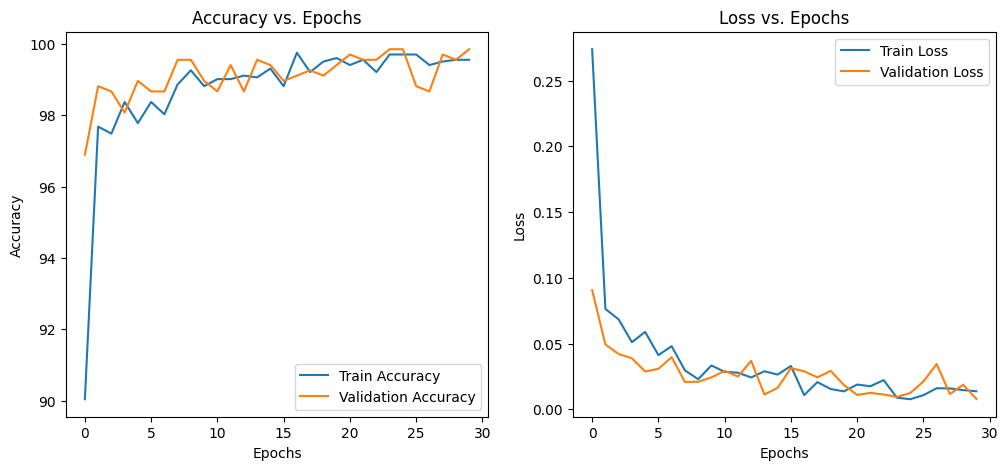

<Figure size 640x480 with 0 Axes>

In [72]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.show()

save_plot("Accuracy vs. Epochs", f"{model_name}")
save_plot("Loss vs. Epochs", f"{model_name}")

In [73]:
encoder = OneHotEncoder(sparse=False)
true_labels_onehot = encoder.fit_transform(true_labels_bin)

/home/raziyeh/miniconda3/envs/anar/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


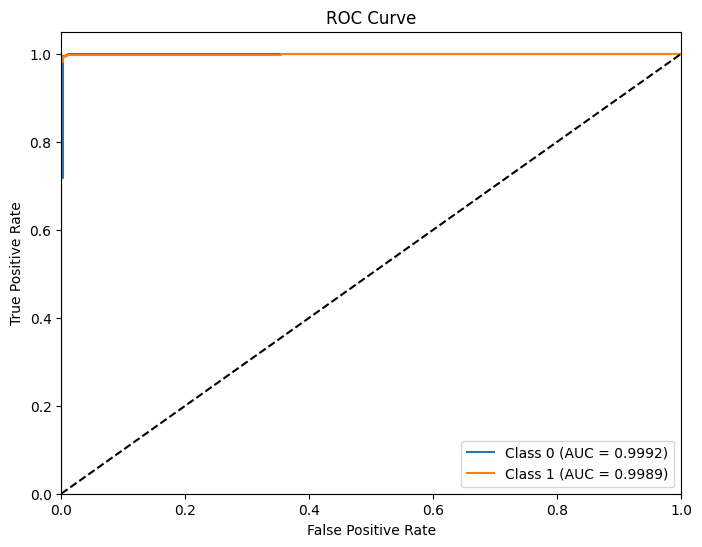

<Figure size 640x480 with 0 Axes>

In [80]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

save_plot("roc_curve", f"{model_name}")

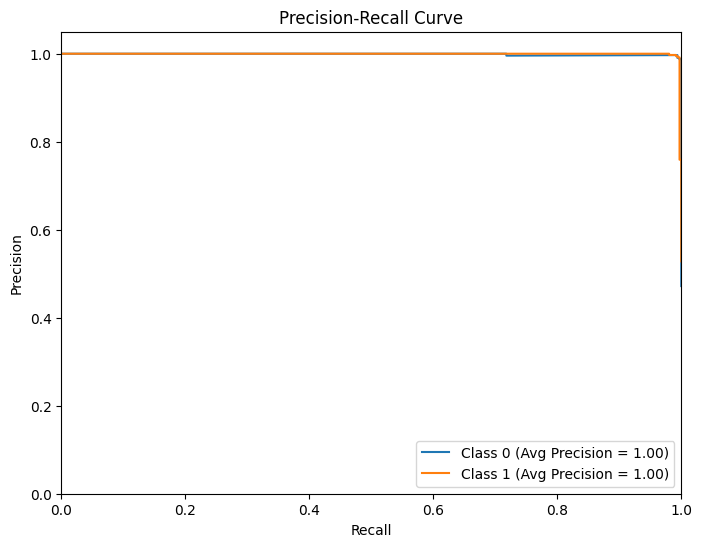

<Figure size 640x480 with 0 Axes>

In [81]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_onehot[:, i], predicted_scores[:, i])
    average_precision[i] = average_precision_score(true_labels_onehot[:, i], predicted_scores[:, i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (Avg Precision = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

save_plot("Precision-Recall", f"{model_name}")

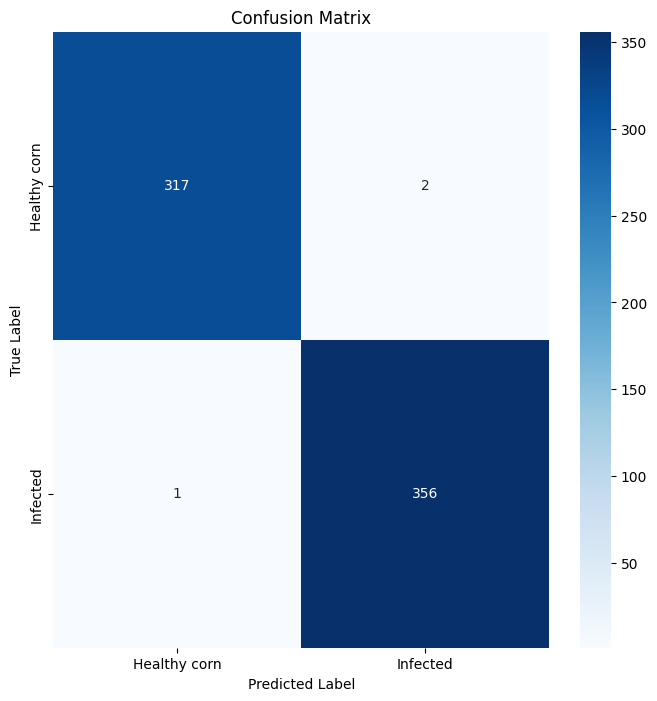

<Figure size 640x480 with 0 Axes>

In [82]:
classes = combined_dataset.classes

predicted_classes = np.argmax(predicted_scores, axis=1)
cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

save_plot("Confusion Matrix", f"{model_name}")

In [91]:
precision_per_class = precision_score(true_labels, predicted_classes, average=None)
recall_per_class = recall_score(true_labels, predicted_classes, average=None)
f1_per_class = f1_score(true_labels, predicted_classes, average=None)

precision_micro = precision_score(true_labels, predicted_classes, average='micro')
recall_micro = recall_score(true_labels, predicted_classes, average='micro')
f1_micro = f1_score(true_labels, predicted_classes, average='micro')

precision_macro = precision_score(true_labels, predicted_classes, average='macro')
recall_macro = recall_score(true_labels, predicted_classes, average='macro')
f1_macro = f1_score(true_labels, predicted_classes, average='macro')

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1 Score per class:", f1_per_class)

print("\nMicro-average:")
print(f'Precision: {precision_micro:.4f}')
print(f'Recall: {recall_micro:.4f}')
print(f'F1 Score: {f1_micro:.4f}')

print("\nMacro-average:")
print(f'Precision: {precision_macro:.4f}')
print(f'Recall: {recall_macro:.4f}')
print(f'F1 Score: {f1_macro:.4f}')

save_metrics_to_pdf(
    true_labels, predicted_classes, precision_per_class, recall_per_class, f1_per_class,
    precision_micro, recall_micro, f1_micro, precision_macro, recall_macro, f1_macro,
    model_name=model_name
)

Precision per class: [0.99685535 0.99441341]
Recall per class: [0.99373041 0.99719888]
F1 Score per class: [0.99529042 0.9958042 ]

Micro-average:
Precision: 0.9956
Recall: 0.9956
F1 Score: 0.9956

Macro-average:
Precision: 0.9956
Recall: 0.9955
F1 Score: 0.9955
Results saved to alexnet_metrics_results.pdf
